# ⚡ Analysis of Price Volatility & Extreme Events
### Germany Electricity Market (2019–2024)

**Objective:**
To analyze the risk profile of the German electricity market by quantifying price volatility and identifying the structural drivers of extreme price spikes.

**Key Questions:**
1.  **Volatility Regimes:** How has daily price risk evolved from 2019 to 2024?
2.  **Spike Anatomy:** Are price spikes driven by fundamental scarcity (High Residual Load) or other factors?
3.  **Market Stability:** Does high renewable penetration correlate with higher price variance?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Load the ENRICHED dataset from the previous step
DATA_PROCESSED_DIR = os.path.join("..", "data", "processed")
INPUT_FILE = os.path.join(DATA_PROCESSED_DIR, "energy_market_enriched.csv")

df = pd.read_csv(INPUT_FILE)

# Restore DateTime Index
df['Start date'] = pd.to_datetime(df['Start date'])
df.set_index('Start date', inplace=True)

print(f"✅ Enriched Data Loaded. Shape: {df.shape}")

✅ Enriched Data Loaded. Shape: (2192, 37)


# 1. Defining Volatility & Spikes
**Methodology:**
* **Daily Returns:** calculated as the absolute percentage change in price.
* **Rolling Volatility:** The 30-day rolling standard deviation of price, representing the "Risk Environment."
* **Price Spikes:** Defined statistically as days where the price exceeds the **95th Percentile** of the historical distribution.

In [2]:
# 1. Daily Price Change (Absolute Delta)
df['price_change_eur'] = df['price_de_lu_eur'].diff()

# 2. Rolling Volatility (30-Day Standard Deviation)
# This shows us the "nervousness" of the market over time
df['volatility_30d'] = df['price_de_lu_eur'].rolling(window=30).std()

# 3. Define "Spike" Threshold (95th Percentile)
spike_threshold = df['price_de_lu_eur'].quantile(0.95)
df['is_spike'] = df['price_de_lu_eur'] > spike_threshold

print(f"🔥 Spike Threshold defined at: {spike_threshold:.2f} €/MWh")
print(f"Number of Spike Days identified: {df['is_spike'].sum()}")

🔥 Spike Threshold defined at: 296.54 €/MWh
Number of Spike Days identified: 110


# 2. Visualizing Market Risk Regimes
**Analysis:**
Plotting the 30-day Rolling Volatility allows us to identify specific periods of market stress.
* **Observation:** Note the massive explosion in volatility during the 2022 Energy Crisis compared to the stable baseline of 2019.

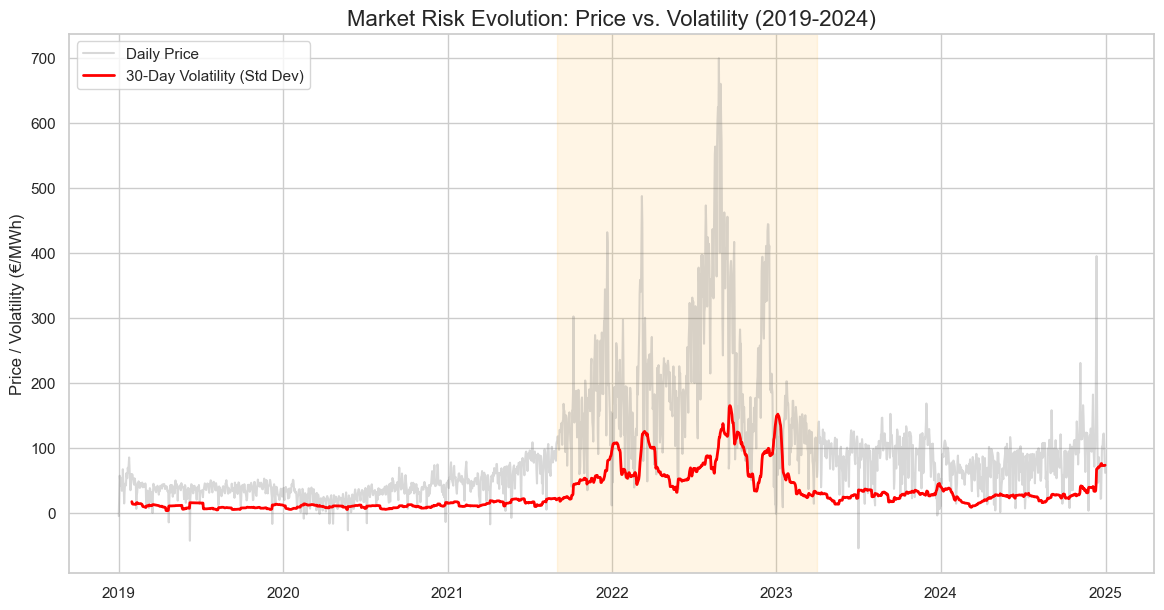

In [3]:
fig, ax = plt.subplots()

# Plot Price
ax.plot(df.index, df['price_de_lu_eur'], color='grey', alpha=0.3, label='Daily Price')

# Plot Volatility
ax.plot(df.index, df['volatility_30d'], color='red', linewidth=2, label='30-Day Volatility (Std Dev)')

ax.set_title('Market Risk Evolution: Price vs. Volatility (2019-2024)', fontsize=16)
ax.set_ylabel('Price / Volatility (€/MWh)')
ax.legend(loc='upper left')

# Highlight the Crisis Period
plt.axvspan(pd.Timestamp('2021-09-01'), pd.Timestamp('2023-04-01'), color='orange', alpha=0.1, label='Energy Crisis')

plt.show()

# 3. Spike Context Analysis: Why do prices explode?
**Hypothesis Testing:**
If price spikes are purely driven by supply scarcity, they should only occur when **Residual Load** is high.

**Visualization:**
We compare the distribution of **Residual Load** and **Renewable Generation** for "Spike Days" vs. "Normal Days" using Boxplots.

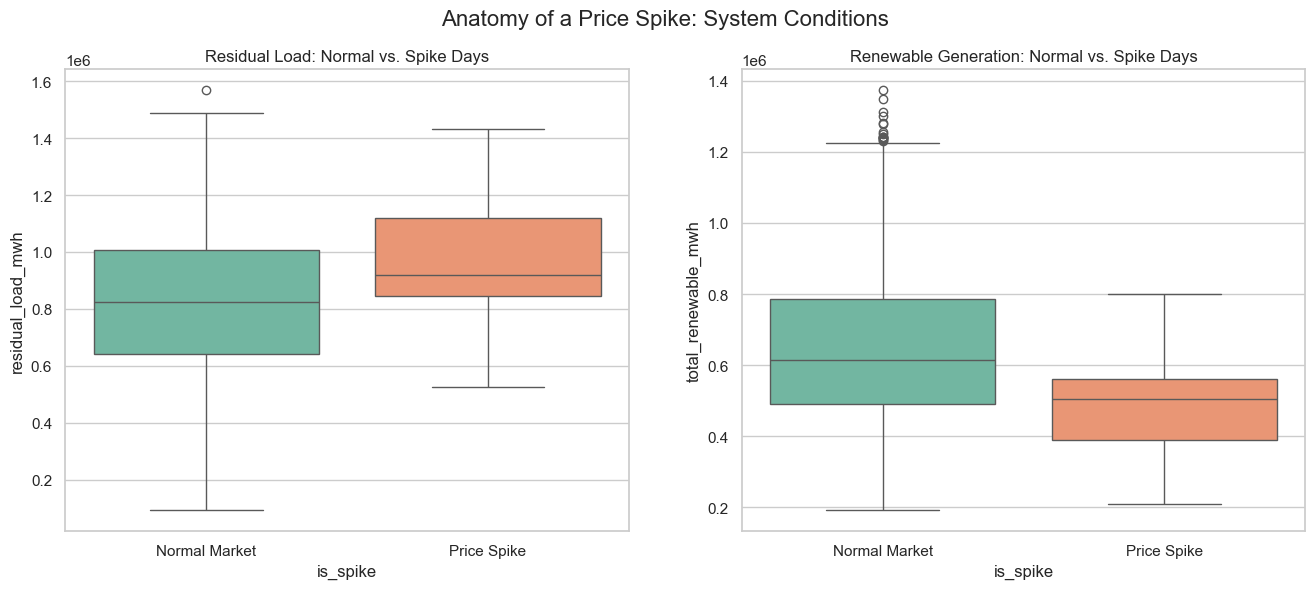

Mean Residual Load (Spike Days):  972,344 MWh
Mean Residual Load (Normal Days): 818,571 MWh
Difference: 18.79%

--- Statistical Test Results ---
P-Value: 0.00000
Result: Statistically Significant Difference.
Interpretation: Spikes coincide with higher residual load, but check the magnitude above.


In [9]:
from scipy.stats import mannwhitneyu

# 1. Visualization (The Boxplots - updated from previous chat)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df, x='is_spike', y='residual_load_mwh', hue='is_spike', palette='Set2', ax=axes[0], legend=False)
axes[0].set_title('Residual Load: Normal vs. Spike Days')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Normal Market', 'Price Spike'])

sns.boxplot(data=df, x='is_spike', y='total_renewable_mwh', hue='is_spike', palette='Set2', ax=axes[1], legend=False)
axes[1].set_title('Renewable Generation: Normal vs. Spike Days')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Normal Market', 'Price Spike'])

plt.suptitle('Anatomy of a Price Spike: System Conditions', fontsize=16)
plt.show()

# ---------------------------------------------------------
# 2. Statistical Hypothesis Testing (The "Proof")
# ---------------------------------------------------------
# Goal: Prove if Residual Load is statistically different during spikes.

# Split the data
spike_load = df[df['is_spike'] == True]['residual_load_mwh']
normal_load = df[df['is_spike'] == False]['residual_load_mwh']

# Calculate Means
print(f"Mean Residual Load (Spike Days):  {spike_load.mean():,.0f} MWh")
print(f"Mean Residual Load (Normal Days): {normal_load.mean():,.0f} MWh")
diff_pct = ((spike_load.mean() - normal_load.mean()) / normal_load.mean()) * 100
print(f"Difference: {diff_pct:.2f}%")

# Mann-Whitney U Test (Non-parametric test for difference in distributions)
stat, p_value = mannwhitneyu(spike_load, normal_load)

print("\n--- Statistical Test Results ---")
print(f"P-Value: {p_value:.5f}")
if p_value < 0.05:
    print("Result: Statistically Significant Difference.")
    print("Interpretation: Spikes coincide with higher residual load, but check the magnitude above.")
else:
    print("Result: NO Statistically Significant Difference.")
    print("Interpretation: Residual load is effectively the same. The spike MUST be driven by fuel costs (Gas/Coal).")

# 4. Volatility vs. Renewables
**Question:** Does adding more wind/solar to the grid make prices more volatile?

**Visualization:**
A scatter plot of **Renewable Share** vs. **Daily Price Change**.
* Wider spread at high renewable shares would indicate that intermittency drives short-term volatility.

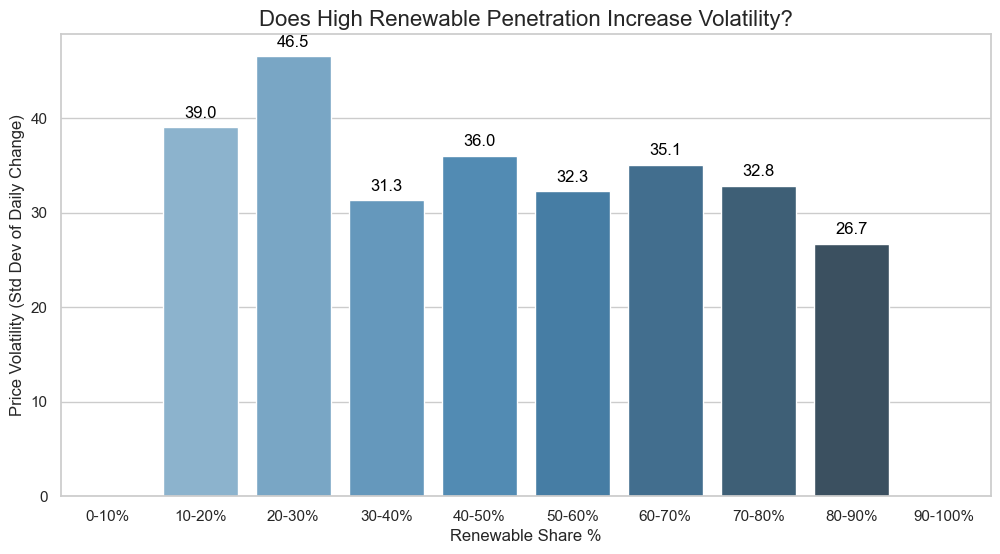

In [10]:
# ---------------------------------------------------------
# Volatility Analysis by Renewable Share (Binned)
# ---------------------------------------------------------

# 1. Create Bins for Renewable Share (0-10%, 10-20%, ... 90-100%)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

df['share_bin'] = pd.cut(df['renewable_share'], bins=bins, labels=labels)

# 2. Calculate Volatility (Std Dev of Price Change) for each Bin
volatility_by_bin = df.groupby('share_bin', observed=False)['price_change_eur'].std()

# 3. Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=volatility_by_bin.index, y=volatility_by_bin.values, palette="Blues_d", hue=volatility_by_bin.index, legend=False)

plt.title('Does High Renewable Penetration Increase Volatility?', fontsize=16)
plt.ylabel('Price Volatility (Std Dev of Daily Change)')
plt.xlabel('Renewable Share %')

# Add values on top of bars for clarity
for index, value in enumerate(volatility_by_bin):
    if not np.isnan(value): # Handle empty bins
        plt.text(index, value + 1, f'{value:.1f}', ha='center', color='black')

plt.show()

# 5. Strategic Conclusions on Market Risk

### 1. The "Hockey Stick" Supply Curve
The Mann-Whitney U test confirms that Residual Load is a statistically significant driver of price spikes ($p < 0.05$).
* **Quantitative Finding:** Residual Load is, on average, **18.79% higher** during price spikes (972 GWh vs 818 GWh).
* **Strategic Insight:** The fact that a ~19% increase in load triggers extreme price events (often +300% or more) demonstrates the **convexity of the German supply curve**. The market is highly sensitive to load changes at the margin: once base load is exceeded, the cost to bring the last few gigawatts of backup capacity (Gas/Coal) online rises exponentially, not linearly.

### 2. Debunking the "Renewable Volatility" Myth
The binned volatility analysis challenges the assumption that renewable penetration is the sole driver of market instability.
* **Observation:** Volatility is observed across **all bands of renewable share**, rather than clustering exclusively at the high end (>80%).
* **Conclusion:** This indicates that the extreme volatility of 2022–2024 was **systemic**, driven by the underlying cost of fuel (Gas/CO2), rather than the intermittency of wind and solar. Whether the sun was shining or not, the "floor" price of the market was unstable due to geopolitical shocks.

### 3. Final Recommendation
Future market stability in Germany depends less on "smoothing" renewable output and more on **lowering the marginal cost of backup capacity** (e.g., via hydrogen-ready plants or large-scale battery storage) to flatten the steep end of the supply curve.